<h2>Interpreting Deep Learning Models for Computer Vision</h2>
<p>
    Interpreting machine learning and deep learning models is a required task in the data science lifecycle since data scientists or machine learning engineers are often involved with serving the models into production.<br><br>
    Interpreting a model is essencial to know how the "black box" is working, questions such as:
    <ul>
        <li>How does a machine learning or deep learning model generates its decisions?</li>
        <ul>
            <li>It is good to know the inner workings of the chosen model, <i>the science tha makes the model work.</i></li>
        </ul>
        <li>Are those decission reliable?</li>
        <ul>
            <li>This is the question that gets an aswer by the area of <i>Explainable Artificial Intelligence.</i></li>
        </ul>
    </ul>
    <br>
    Performance metrics are not the only way for evaluating how good or bad a model performs, the model must answer questions for fairnes, transparency and accountability for any model being used to solve real-world problems.
    <img src='images/questions_EAI.png' height=200px width=600px/>
    <br>
    <i>The main objective of this notebook is to answer the question <b>What do Deep Learning Models for Computer Visions See?</b></i>
    <br><br>
    <i>The general objectives of this notebook is to explain and use concepts, techniques and tools to interpret and understand deep learning models used in Computer Vision</i>, the architecture that will be used is a <b>Convolutional Neural Network</b>. The Deep Learning Models will be implemented using <i>Keras</i> and <i>Tensorflow 2.0</i> and some open-source tools to interpret decisions made by these models.
    <br><br>
</p>
<h2>Convolutional Neural Networks</h2>
<p>
    CNNs are the most influential and popular architecture for computer vision problems.
    <br>
    <img src='images/cnn_visualization.gif' alt='Source: becominghuman.ai'/>
    <br>
    CNNs are usually designed by multiple convolution and pooling layers, these layers help in automatically extracting relevant features from visual data, like images, video (sequence of images), thanks to this multi-layered architecture CNNs learn a robust hierarchy of features, which are spatial, rotation and translation invariant.
    <br>
    <img src='images/cnn_EAI.png'/>
    <br>
    The main steps/process in a CNN model are visually shown in the above figure. Any image can be represented as a tensor of pixels values. The convolution layers help in extracting features from an image, these process generates a <i>feature map</i>.
    <br><br>
    The layers that are closer to the input data in the network learn very generic features like edges, corners and so on, these layers learn what is called <i>hierarchical spatio-temporal features.</i>
    <br><br>
    Deeper layers in the network (these layers are close to the output layer) learn very specific features pertaining to the input image. The following graphic summarizes the main aspects of any CNN model.
    <br><br>
    <img src='images/cnn_EA1_2.png'/>
    <br><br>
    As it is being tried to explain and understand how CNN models perceive images, the process of training a CNN model from scratch won't be implemented, rather  a <b>VGG-16</b> model will be implemented leveraging the power of <a href=''>transfer learning</a>.
    <br>
    <img src='images/vgg16_arch.png'/>
    <br>
    <b>VGG-16</b> pre-trained model on the popular image dataset <b>ImageNet</b>, its popularity comes from its diverse image categories (around 1000 different categories) and that is formed by over a million images. Due this fact the model has already learned  a robust hierarchy of features, therefore the model can perfom well as a <a href=''>feature extractor</a> for new images <i>suitable</i> for computer vision problem.
    <br>
    <h3>Interpreting CNN Models <i>What does a Deep Learning Model see?</i></h3>
    <br>
    Unbox the seemingly black-box CNN model to understand <i>what is going on under the hood?</i> and <i>what does the model see when it looks at an image?</i> To give appropiate answers to these questions there are a wide  variety of <b><i>techniques and tools for interpreting decision made by vision-base Deep Learning Models</i></b>.
    <br>
    <img src='images/techniques_DLEAI.png'/>
    <br>
    These techniques will be explained through its implementation on Keras and TensorFlow.
    <br>
    <h3>SHAP Gradient Explainer</h3>
    <br>
    This technique tries to combine a multitude of ideas from
    Integrated Gradients, SHapley Additive exPlanations (SHAP) and
    SmoothGrad. This technique tries to explain model decisions using
    expected gradients (an extension of integrated gradients). This is
    a feature attribution method designed for differentiable models
    based on an extension of Shapley values to infinite player games.
    Thanks to the <code>shap</code> framework this technique will be
    implemented. It is necessary to install this framework, it can be installed by executing the command <code>pip install shap</code>.
    <br><br>
    Integrated gradients values are a bit different from SHAP values, 
    and require a single reference value to integrate from. However in 
    SHAP Gradient Explainer, expected gradients reformulates the 
    integral as an expectation and combines that expectation with 
    sampling reference values from the background dataset. Thus this 
    technique uses an entire dataset as the background distribution 
    versus just a single reference value. Let’s try and implement this 
    on some sample images.
    <br><br>
    Firs it is necessary to load up some basic dependencies and model
    visualization function utilities.
</p> 

In [2]:
import keras as K
from keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.colors import LinearSegmentedColormap
import numpy as np
import shap
import json
import requests

import tensorflow as tf
from tf_explain.core.activations import ExtractActivations
from tf_explain.core.occlusion_sensitivity import OcclusionSensitivity
from tf_explain.core.grad_cam import GradCAM
from tf_explain.core.smoothgrad import SmoothGrad
from tensorflow.keras.applications.xception import decode_predictions
import os
os.environ['CUDA_VISIBLE_DEVICES'] = "0"

shap.initjs()

Using TensorFlow backend.
Intel(R) Data Analytics Acceleration Library (Intel(R) DAAL) solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


<p>
    The next method will be used for visualizing SHAP values in larger
    image formats, this modifies the <code>shap.image_plot(...)</code>
    function.
</p>

In [8]:
def visualize_model_decisions(shap_values, x, labels=None, figsize=(20, 30)):
    
    colors = []
    for l in np.linspace(1, 0, 100):
        colors.append((30./255, 136./255, 229./255,l))
    for l in np.linspace(0, 1, 100):
        colors.append((255./255, 13./255, 87./255,l))
    red_transparent_blue = LinearSegmentedColormap.from_list("red_transparent_blue", colors)

    multi_output = True
    if type(shap_values) != list:
        multi_output = False
        shap_values = [shap_values]

    # make sure labels
    if labels is not None:
        assert labels.shape[0] == shap_values[0].shape[0], "Labels must have same row count as shap_values arrays!"
        if multi_output:
            assert labels.shape[1] == len(shap_values), "Labels must have a column for each output in shap_values!"
        else:
            assert len(labels.shape) == 1, "Labels must be a vector for single output shap_values."

    # plot our explanations
    fig_size = figsize
    fig, axes = plt.subplots(nrows=x.shape[0], ncols=len(shap_values) + 1, figsize=fig_size)
    if len(axes.shape) == 1:
        axes = axes.reshape(1,axes.size)
    for row in range(x.shape[0]):
        x_curr = x[row].copy()

        # make sure
        if len(x_curr.shape) == 3 and x_curr.shape[2] == 1:
            x_curr = x_curr.reshape(x_curr.shape[:2])
        if x_curr.max() > 1:
            x_curr /= 255.
        
        axes[row,0].imshow(x_curr)
        axes[row,0].axis('off')
        
        # get a grayscale version of the image
        if len(x_curr.shape) == 3 and x_curr.shape[2] == 3:
            x_curr_gray = (0.2989 * x_curr[:,:,0] + 0.5870 * x_curr[:,:,1] + 0.1140 * x_curr[:,:,2]) # rgb to gray
        else:
            x_curr_gray = x_curr

        if len(shap_values[0][row].shape) == 2:
            abs_vals = np.stack([np.abs(shap_values[i]) for i in range(len(shap_values))], 0).flatten()
        else:
            abs_vals = np.stack([np.abs(shap_values[i].sum(-1)) for i in range(len(shap_values))], 0).flatten()
        max_val = np.nanpercentile(abs_vals, 99.9)
        for i in range(len(shap_values)):
            if labels is not None:
                axes[row,i+1].set_title(labels[row,i])
            sv = shap_values[i][row] if len(shap_values[i][row].shape) == 2 else shap_values[i][row].sum(-1)
            axes[row,i+1].imshow(x_curr_gray, cmap=plt.get_cmap('gray'), alpha=0.15, extent=(-1, sv.shape[0], sv.shape[1], -1))
            im = axes[row,i+1].imshow(sv, cmap=red_transparent_blue, vmin=-max_val, vmax=max_val)
            axes[row,i+1].axis('off')
        
    cb = fig.colorbar(im, ax=np.ravel(axes).tolist(), label="SHAP value", orientation="horizontal", aspect=fig_size[0]/0.2)
    cb.outline.set_visible(False)

<p>
    The next step is to load a pre-trained <code>VGG-16</code> model, which was trained previously on the <code>Imagenet</code> dataset.
</p>

In [9]:
model = VGG16(weights='imagenet', include_top=True)
model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

<p>
    When the CNN model is loaded, a small set of images from the dataset is going to be loaded to be used as a background distribution and use four sample images for model interpretation.
</p>

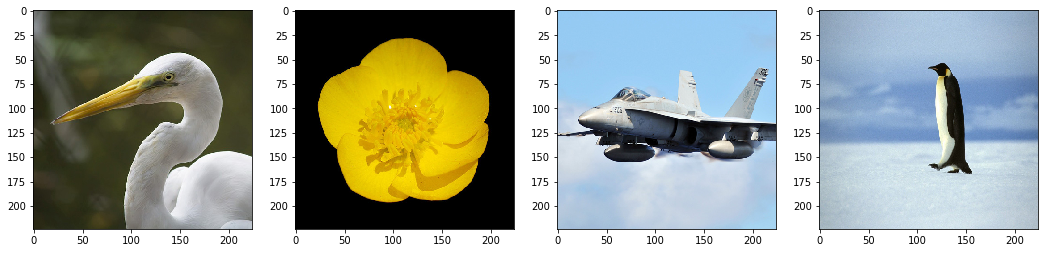

In [10]:
# Load sample images
X, y = shap.datasets.imagenet50()

# Load sample cat image for test
IMAGE_PATH = 'images/penguin.jpeg'
img = K.preprocessing.image.load_img(IMAGE_PATH, target_size=(224, 224))
img = K.preprocessing.image.img_to_array(img)

# Select 3 other sample images for test
to_predict = np.array([X[1], X[15], X[49], img])
fig, ax = plt.subplots(1, 4, figsize=(18, 10))
ax[0].imshow(to_predict[0]/255.)
ax[1].imshow(to_predict[1]/255.)
ax[2].imshow(to_predict[2]/255.)
ax[3].imshow(to_predict[3]/255.)

<p>
    There are four different types of images, now the <code>VGG-16</code> model will be used for prediction on these images.
</p>

In [11]:
# Get Imagenet ID to label name mappings
url = "https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json"
fname = shap.datasets.cache(url)
with open(fname) as f:
    class_names = json.load(f)
    
# Make Model Predictions
predictions = model.predict(preprocess_input(to_predict.copy()))

# Get Prediction Labels
predicted_labels = [class_names.get(str(pred)) for pred in np.argmax(predictions, axis=1)]
print(predicted_labels)

[['n02009912', 'American_egret'], ['n07717410', 'acorn_squash'], ['n04552348', 'warplane'], ['n02056570', 'king_penguin']]


<p>
    <h3>What does the <code>VGG-16</code> model see?</h3>
    <br>
    In the 7th layer of the Neural Network, which usually is one of the closest layers in the model.
</p>

In [12]:
# Utility function to pass inputs to specific model layers
def map2layer(x, layer):
    feed_dict = dict(zip([model.layers[0].input], [preprocess_input(x.copy())]))
    return K.get_session().run(model.layers[layer].input, feed_dict)

In [13]:
# Focus on the 7th layer of CNN model
print(model.layers[7].input)

Tensor("block2_pool_1/MaxPool:0", shape=(None, 56, 56, 128), dtype=float32)


In [14]:
# Make Model Predictions
e = shap.GradientExplainer((model.layers[7].input, model.layers[-1].output), 
                            map2layer(preprocess_input(X.copy()), 7))
shap_values, indexes = e.shap_values(map2layer(to_predict, 7), ranked_outputs=2)
index_names = np.vectorize(lambda x: class_names[str(x)][1])(indexes)
print(index_names)

TypeError: Tensor is unhashable if Tensor equality is enabled. Instead, use tensor.experimental_ref() as the key.

In [ ]:
# Visualize Model Decisions
visualize_model_decisions(shap_values=shap_values, x=to_predict, 
                          labels=index_names, figsize=(20, 40))

<p>
    Now it can be graphically seen the predictions of the model for each image and why did take such decisions. The next cell will execute the code for visualizing what the <code>VGG-16</code> model sees in deeper layers, the layer that is going to be visualize is the 14th layer's decisions.  
</p>

<h2>Understanding Predictions of CNN models built with TensorFlow 2.0</h2>
<p>
    There are four more techniques for interpreting the predictions of a CNN model, these will be used to interpretate a pre-trained model using TensorFlow 2.0 and the framework <code>tf-explain</code>, this framework can be installed by the command: <code>pip install tf-explain</code>.
    <br>
    <h3>Load Pre-trained CNN Model</h3>
    <br>
    The model that is going to be used is one of the most complex pre-trained CNN models, is an <a href='https://arxiv.org/pdf/1610.02357.pdf'>Xception model</a>.
</p>

In [3]:
# Load Xception pre-trained CNN model
model = tf.keras.applications.xception.Xception(weights='imagenet', 
                                                include_top=True)
model.summary()

Model: "xception"

Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 149, 149, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 149, 149, 32) 0           block1_conv1_bn[0][0]            
___________________________________________________________________________________________

<p>
    From the model architecture snapshot above that this model has a total of 14 blocks with multiple layers in each block.
    <br>
    <h3>Model Predictions on Sample Image</h3>
    <br>
    Let's reuse the sample image and make the top-5 predictions with the <code>Xception</code> model. First the image will be loaded.
</p>

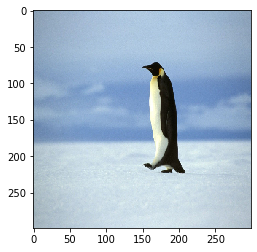

In [4]:
# Load and pre-process cat image
IMAGE_PATH = 'images/penguin.jpeg'
img = tf.keras.preprocessing.image.load_img(IMAGE_PATH, target_size=(299, 299))
img = tf.keras.preprocessing.image.img_to_array(img)

img_inp = tf.keras.preprocessing.image.load_img(IMAGE_PATH, target_size=(299, 299))
img_inp = tf.keras.preprocessing.image.img_to_array(img_inp)

# View the image
plt.imshow(img/255)

<p>
Now it is time for making the top 5-predictions on this image using the <code>Xception</code> model. The image is pre-processed before inference.
</p>

In [5]:
# Load imagenet id to class label mappings

response = requests.get('https://storage.googleapis.com/download.tensorflow.org/data/imagenet_class_index.json')
imgnet_map = response.json()
imgnet_map = {v[1]: k for k, v in imgnet_map.items()}

In [6]:
# Make Model Predictions
img = tf.keras.applications.xception.preprocess_input(img)
predictions = model.predict(np.array([img]))
decode_predictions(predictions, top=5)

[[('n02056570', 'king_penguin', 0.96148866),
  ('n02071294', 'killer_whale', 0.001818398),
  ('n02077923', 'sea_lion', 0.00034432983),
  ('n01843383', 'toucan', 0.000334301),
  ('n01531178', 'goldfinch', 0.00028563675)]]

<p>
    The first prediction states that the image corresponds to a king 
    penguin with a 96% of certainity while the rest of predictions 
    state that the image might correspond to a killer whale, sea lion 
    or even a tuocan, these predictions have very similar features to a 
    penguin.
    <br>
    <h3>Activation Layer Visualization</h3>
    <br>
    This techniques is typically used to visualize how a given input comes out of specific activation layer. The main idea is to explore which feature maps are getting activated in the model and visualize them. Usually this is done by lookig at each specific layer. The following code showcases activation layer visualizations for one of the layers in Block 2 of the CNN model.
</p>

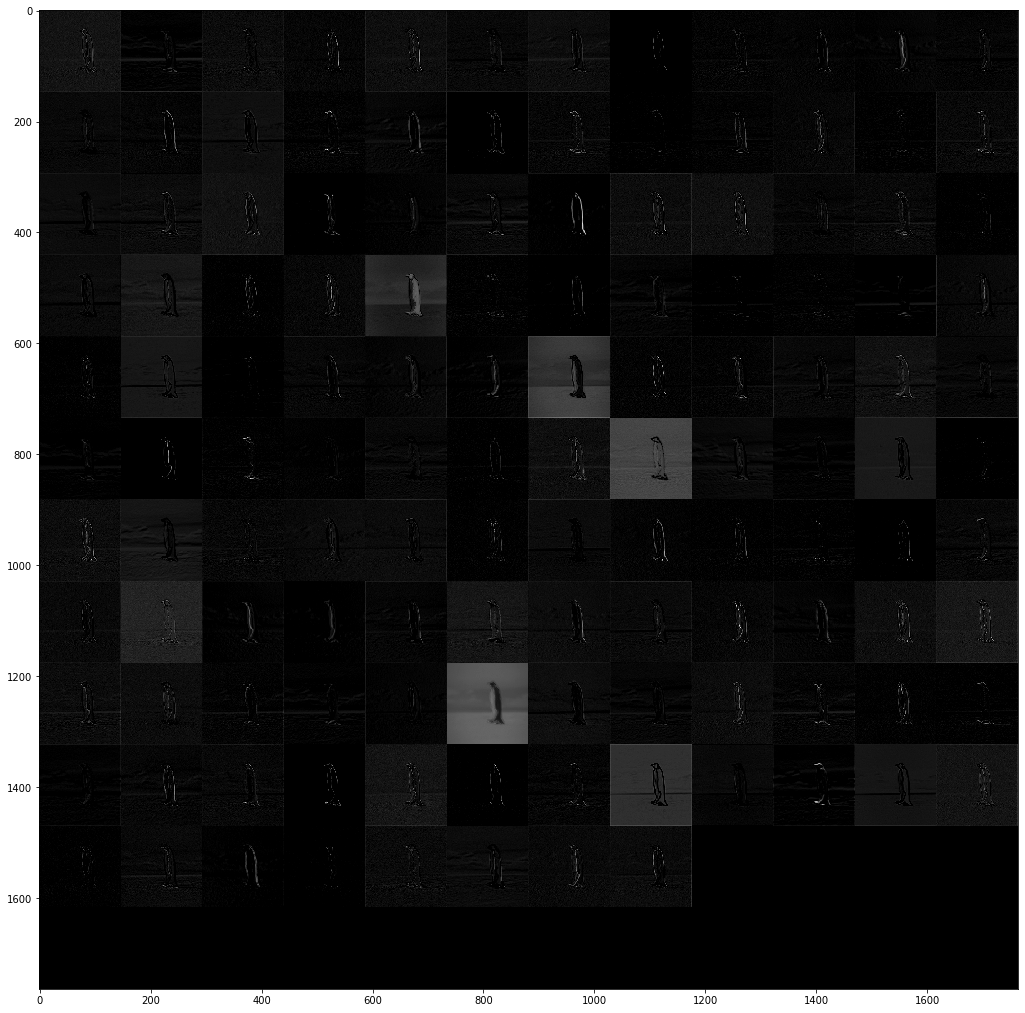

In [19]:
explainer = ExtractActivations()
grid = explainer.explain((np.array([img]), None), model, ['block2_sepconv2_act'])
fig, ax = plt.subplots(figsize=(18, 18))
ax.imshow(grid, cmap='binary_r')

<p>
    This provides an idea of which feature maps are getting activated and what parts of the images are typically focused.
    <br>
    <h3>Occlusion Sensitivity</h3>
    <br>
    This technique basically tries to visualize how parts of the image affects the confidence of the neural network by occluding (hiding) parts iteratively. This is done by systematically occluding different portions of the input image with a grey square and monitoring the output of the classifier.
</p>

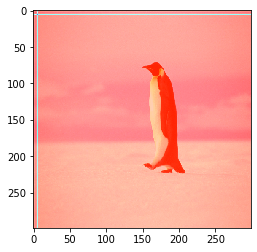

In [20]:
# Get label imagenet ID
imgnet_map['king_penguin']

explainer = OcclusionSensitivity()
grid = explainer.explain(([img_inp], None), model, 285, 7)
fig, ax = plt.subplots(figsize=(4, 4))
plt.imshow(grid)

<p>
    Specific patches of the images should be highlighted in red/yellow, 
    like a heatmap but for the image in the sample used, it kind of 
    highlighted the overall image in a red hue, the reason for this 
    could be because of the zoomed image, however the sides of the 
    image has a higher intensity focusing more on the shape of the 
    penguin rather than the textuer of the image.
    <br>
    <h3>GradCAM</h3>
    <br>
    This is perhaps one of the most popular and effective methods for interpreting CNN models. Using <code>GradCAM</code>, it lets to try and visualize how parts of the image affects the neural network output by looking into the <b>class activation maps (CAM)</b>. Class activation maps are a simple technique to get the discriminative image regions used by a CNN to identify a specific class in the image. In simple words <b>a class activation map (CAM) shows which regions in the image were relevant to the class.</b> 
    <ul>
        <li>The output of <i>grad-CAM</i> will be pixels that contribute to the maximization of a target function. If for example you are interested in what maximizes category number 187, then zero out all the other categories.</li>
        <li>Compute the gradients of the target function, with respect to the convolutional layer outputs. This can be donde efficiently with <b>backpropagation</b>.</li>
    </ul>
    Given an image and a class of interest (e.g., ‘king penguin’ or any 
    other type of differentiable output) as input, the model forwards 
    propagate the image through the CNN part of the model and then
    through task- specific computations to obtain a raw score for the 
    category. <b>The gradients are set to zero for all classes except
    the desired class (king penguin), which is set to 1. This 
    signal is then backpropagated to the rectified convolutional 
    feature maps of interest, which we combine to compute the coarse 
    Grad-CAM localization (blue heatmap) which represents where the 
    model has to look to make the particular decision.</b>
    <br><br>
    An implementation of the GradCAM visualizations for specific blocks in our CNN model, it starts by visualizing one of the layers from block 1 (closest/shallower layer).
</p>

In [21]:
explainer = GradCAM()

# Get Imagenet IDs for Penguins
imgnet_map['king_penguin'], imgnet_map['killer_whale'], imgnet_map['sea_lion'], imgnet_map['toucan'], imgnet_map['goldfinch']

('145', '148', '150', '96', '11')

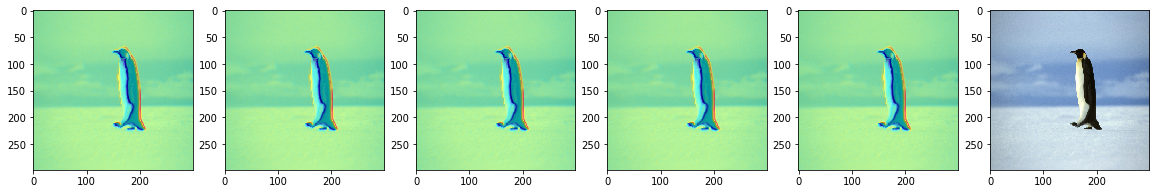

In [22]:
# Visualize GradCAM outputs in Block 1
grid1 = explainer.explain(([img], None), model, 'block1_conv2', 145)
grid2 = explainer.explain(([img], None), model, 'block1_conv2', 148)
grid3 = explainer.explain(([img], None), model, 'block1_conv2', 150)
grid4 = explainer.explain(([img], None), model, 'block1_conv2', 96)
grid5 = explainer.explain(([img], None), model, 'block1_conv2', 11)


fig = plt.figure(figsize = (20, 20))
ax1 = fig.add_subplot(1, 6, 1)
ax1.imshow(img_inp / 255.)
ax1.imshow(grid1, alpha=0.6)
ax2 = fig.add_subplot(1, 6, 2)
ax2.imshow(img_inp / 255.)
ax2.imshow(grid2, alpha=0.6)
ax3 = fig.add_subplot(1, 6, 3)
ax3.imshow(img_inp / 255.)
ax3.imshow(grid3, alpha=0.6)
ax4 = fig.add_subplot(1, 6, 4)
ax4.imshow(img_inp / 255.)
ax4.imshow(grid4, alpha=0.6)
ax5 = fig.add_subplot(1, 6, 5)
ax5.imshow(img_inp / 255.)
ax5.imshow(grid5, alpha=0.6)
ax6 = fig.add_subplot(1, 6, 6)
ax6.imshow(img_inp / 255.)

<p>
    Due that this is one of the closer/shallow layers, it can be seen higher level features like edges and corners (of those that belong to colors such as black and white) being activated in the network, next the output from deeper layers of the Block 6 in the network will be visualize.
</p>

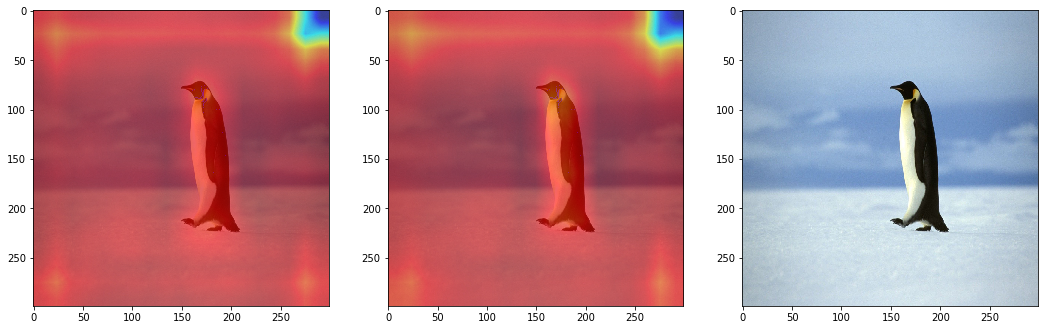

In [23]:
# Visualize GradCAM output from Block 6
grid1 = explainer.explain(([img], None), model, 'block6_sepconv1', 145)
grid2 = explainer.explain(([img], None), model, 'block6_sepconv1', 148)


fig = plt.figure(figsize = (18, 18))
ax1 = fig.add_subplot(1, 3, 1)
ax1.imshow(img_inp / 255.)
ax1.imshow(grid1, alpha=0.6)
ax2 = fig.add_subplot(1, 3, 2)
ax2.imshow(img_inp / 255.)
ax2.imshow(grid2, alpha=0.6)
ax3 = fig.add_subplot(1, 3, 3)
ax3.imshow(img_inp / 255)

<p>
    The Network starts paying attention to the areas where are predominated by the color white and where the penguin is, in the next cell one of the deepest layer will be explored. The Block 14 is going to be explored.
</p>

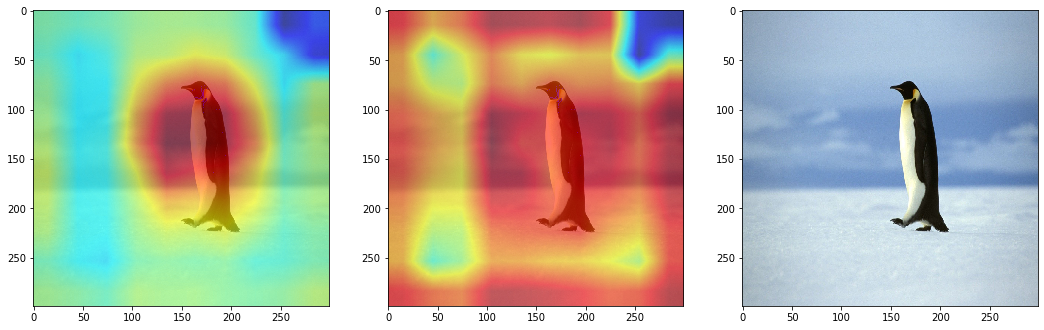

In [24]:
grid1 = explainer.explain(([img], None), model, 'block14_sepconv1', 145)
grid2 = explainer.explain(([img], None), model, 'block14_sepconv1', 148)


fig = plt.figure(figsize = (18, 18))
ax1 = fig.add_subplot(1, 3, 1)
ax1.imshow(img_inp / 255.)
ax1.imshow(grid1, alpha=0.6)
ax2 = fig.add_subplot(1, 3, 2)
ax2.imshow(img_inp / 255.)
ax2.imshow(grid2, alpha=0.6)
ax3 = fig.add_subplot(1, 3, 3)
ax3.imshow(img_inp / 255)

<p>
    As can be seen the model for the prediction of <i>King Penguin</i> 
    it focuses on an oval shaped area surrounding the penguin while for 
    the prediction of <i>Killer Whale</i> the area surrounding the 
    penguin is squared shaped and bigger, more notable differences can 
    be seen, such as for the prediction of <i>King Penguin</i> the 
    model stars to stop given attention to some areas, this areas are 
    not being highlighted.
    <br>
    <h3>SmoothGrad</h3>
    <br>
    This technique helps visualizing stabilized gradients on the inputs
    towards the decision. <i><b>The key objective is to identify pixels 
    that strongly influence the final decision.</i></b> A starting point for 
    this strategy is the gradient of the class score function with respect
    to the input image. This gradient can be interpreted as a 
    sensitivity map, and there are several techniques that elaborate on 
    this basic idea.
    <br><br>
    <code>SmoothGrad</code> is a simple method that can help visually 
    sharpen gradient-based sensitivity maps. The core idea is to take 
    an image of interest, sample similar images by adding noise to the 
    image, then take the average of the resulting sensitivity maps for 
    each sampled image.
</p>

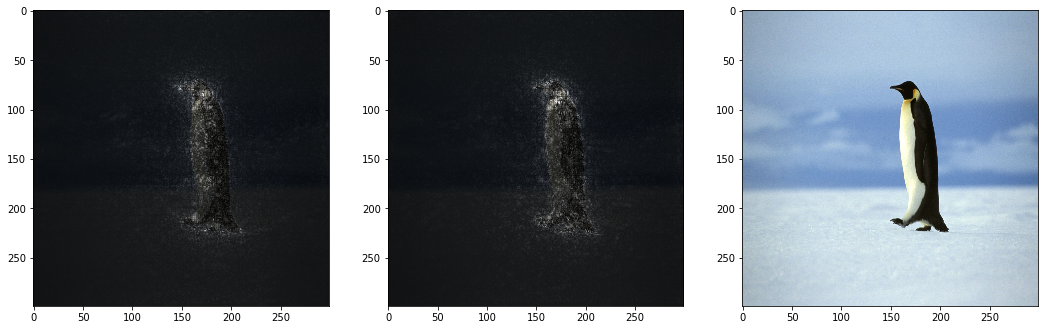

In [7]:
explainer = SmoothGrad()

grid1 = explainer.explain(([img], None), model, 145, 80, .2)
grid2 = explainer.explain(([img], None), model, 148, 80, .2)

fig = plt.figure(figsize = (18, 8))
ax1 = fig.add_subplot(1, 3, 1)
ax1.imshow(img_inp / 255.)
ax1.imshow(grid1, alpha=0.9, cmap='binary_r')
ax2 = fig.add_subplot(1, 3, 2)
ax2.imshow(img_inp / 255.)
ax2.imshow(grid2, alpha=0.9, cmap='binary_r')
ax3 = fig.add_subplot(1, 3, 3)
ax3.imshow(img_inp / 255.)

<p>
    It can be described that for the prediction of <i>King Penguin</i> the network is focused on the peack and the neck, for the prediction of the <i>Killer Whale</i> the netwroks gives more attention to neck and the feet.
    <br>
    <h2>Conclusion</h2>
    <br>
    This notebook provides how a data scientist or machine learning engineer can not only leverage pre-trained complex CNN models to predict on new images but to even try and make an attempt to visualize what the neural network models are really seeing in order to learn.
    <br><br>
    The list of techniques here are not exhaustive but definitely cover some of the most popular and widely used methods to interpret CNN models.
    <br><br>
    As a software engineer student in future works I'll provide more notebooks in which some techniques will be applied in more depth for a better interpretation of deep learning models.
</p>